<a href="https://colab.research.google.com/github/a-garnier/ASDpy/blob/antoine/ASDpy.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# Strategy:
# STEP 1:
#  * load training data for each machine (only normal sounds)
#  * extract each vertical lines from spectrogram as a vector, and complete with machine ID
#  * store these vectors in a global matrix
#  * train a classifier which compute probability of appartenancy for each machine
#
# STEP 2:
#  * do the same with validation data (normal and anomalous sounds)
# si les données correspondent à un défaut, prendre l'oppsé de la valeur
# calculer les proba d'appartenance de chaque son en faisant des batchs par spectrogramme
# spectrogrammes OK : quels résultats / proportion de bons classements
# spectrogrammes défaut : quel résultat / proportion de bons classements

In [2]:
# Author : Antoine
# First try of classification with KNN
# use only fan data, use normal and anomalous data for training
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt # Pour l'affichage d'images

from joblib import dump, load

from sklearn import neighbors
from sklearn.model_selection import train_test_split

#import numpy as np # Pour la manipulation de tableaux
#import pandas as pd # Pour manipuler des DataFrames pandas

from matplotlib import cm # Pour importer de nouvelles cartes de couleur
# %matplotlib inline

from keras.models import Sequential # Pour construire un réseau de neurones
from keras.layers import Dense # Pour instancier une couche dense
from keras.utils import np_utils

import itertools # Pour créer des iterateurs

from sklearn import metrics # Pour évaluer les modèles

In [3]:
from google.colab import drive
drive.mount('/drive')

Drive already mounted at /drive; to attempt to forcibly remount, call drive.mount("/drive", force_remount=True).


In [4]:
machines = [            # TEST DATA SIZE
    'fan',              # (1875, 40065)
    'pump',             # (856, 40065)
    'slider',           # (1290, 40065)
    'ToyCar',           # (2459, 44033)
    'ToyConveyor',      # (3509, 40065)
    'valve'             # (879, 40065)
]

#machines = ['verif_1', 'verif_2']

sets = ['train', 'test']

In [5]:
id_machine = 0
height = 128

# init array with expected width (equals image heigh + one for target)
global_array = np.empty([0, height+1])

set = 'train'

for machine in machines:

    # identifiant de la machine
    id_machine = id_machine + 1

    print(machine, '/', id_machine)

    # example : '../data/fan/train_png/'
    # working_directory = '../../data/'+machine+'/'
    working_directory = '/drive/MyDrive/asdpy/data/'

    # data file example: df_fan_train.joblib
    # numpy ndarray
    # dernière colonne = type de donnée, normal ou anomalie
    data_array = load(working_directory + 'df_'+machine+'_'+set+'.joblib')

    # limit data to spare RAM 
    if data_array.shape[0] > 2500:
      data_array = data_array[:2500,:]

    print(data_array.shape)

    nb_images = data_array.shape[0]
    pixels = data_array.shape[1] - 1
    width = int(pixels/height)

    #print("nb_images : ", nb_images)
    #print("width : ", width)

    loop_array = data_array[:,0:-1].reshape(height,width*nb_images).T

    # vecteur aussi long que le nombre de lignes verticales
    id_machine_col = np.ones((width*nb_images,1), dtype=np.int16)*id_machine

    # colle le vecteur à droite de l'array
    loop_array = np.append(loop_array, id_machine_col, axis=1)
  
    # ajoute au tableau global
    global_array = np.append(global_array, loop_array, axis=0)

    # 14 minutes pour les 4 premieres machines...
    # 16 secondes pour 5 machines une fois optimisé
    # 45 secondes avec les 6 jeux de train et bridage à 2500 lignes par jeu


fan / 1
(2500, 40065)
pump / 2
(2500, 40065)
slider / 3
(2500, 40065)
ToyCar / 4
(2500, 44033)
ToyConveyor / 5
(2500, 40065)
valve / 6
(2500, 40065)


In [6]:
print('global_array.shape : ')
print(global_array.shape)
# (3'477'913, 129)

global_array.shape : 
(4772500, 129)


In [7]:
print(global_array)

[[0.89019608 0.43529412 0.74117649 ... 0.25098041 0.79607844 1.        ]
 [0.87450981 0.47843137 0.72156864 ... 0.18431373 0.76862746 1.        ]
 [0.83137256 0.43137255 0.69411767 ... 0.2        0.69411767 1.        ]
 ...
 [0.59607846 0.78039217 0.52549022 ... 0.69411767 0.49803922 6.        ]
 [0.60000002 0.74117649 0.52549022 ... 0.68235296 0.50588238 6.        ]
 [0.53725493 0.72156864 0.58039218 ... 0.64705884 0.45882353 6.        ]]


In [8]:
print("CREATE TRAINING DATAFRAME...")

# réduit la dimension de l'array pour les tests
np.random.shuffle(global_array)
data = global_array[0:1000*1000,:]

df = pd.DataFrame(data)

# séparation des données de la cible
data = df.iloc[:,0:-1]
target = df.iloc[:,-1:]

print("SPLIT DATA...")
# séparation des données d'entrainement (70%) et de test (30%)
X_train, X_test, y_train, y_test = train_test_split(data, target, test_size = 0.30, random_state=66)

CREATE TRAINING DATAFRAME...
SPLIT DATA...


In [9]:
target.value_counts()

128
4.0    180150
6.0    164424
1.0    164320
2.0    164022
5.0    163661
3.0    163423
dtype: int64

In [10]:
y_train = np_utils.to_categorical(y_train, dtype = 'int')
y_test = np_utils.to_categorical(y_test, dtype = 'int')

print("y_test.shape")
print(y_test.shape)

num_pixels = X_train.shape[1]
num_classes = y_test.shape[1]

print("num_classes : ", num_classes)

y_test.shape
(300000, 7)
num_classes :  7


In [11]:
# 50 units 50 epoch 700k train sample => 5 min

units = 50
epochs = 50

# Étape 1 : Instancier un modèle avec le constructeur Sequential
model = Sequential()

# Étape 2 : Instancier les couches qui composeront le modèle avec leur constructeur
first_layer = Dense(units=units,                # nombre de neurones
                    activation='tanh',          # fonction d'activation
                    input_dim=num_pixels,       # dimension du vecteur d'entrée
                    kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Étape 3 : Ajouter les couches au modèle grâce
second_layer = Dense(units=num_classes,          # nombre de neurones de sortie égal au nombre de classes
                     activation='softmax',       # fonction d'activation
                     #input_dim=20,               # dimension du vecteur d'entrée égale à la sortie de la couche précédente
                     kernel_initializer="normal" # vecteur de poids de cette couche initialisés aléatoirement selon la loi normale
            )

# Ajout des couches aux modèle
model.add(first_layer)
model.add(second_layer)

model.compile(loss='categorical_crossentropy',  # fonction de perte
              optimizer='adam',                 # algorithme d'optimisation
              metrics=['accuracy'])             # métrique d'évaluation


training_history = model.fit(X_train, y_train, epochs=epochs, batch_size=200, validation_split=0.2)

train_acc = training_history.history['accuracy']
val_acc = training_history.history['val_accuracy']



Epoch 1/50
2800/2800 [==============================] - 20s 2ms/step - loss: 1.1551 - accuracy: 0.6058 - val_loss: 0.4449 - val_accuracy: 0.8328
Epoch 2/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.4300 - accuracy: 0.8359 - val_loss: 0.3991 - val_accuracy: 0.8462
Epoch 3/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.3886 - accuracy: 0.8505 - val_loss: 0.3793 - val_accuracy: 0.8499
Epoch 4/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.3561 - accuracy: 0.8625 - val_loss: 0.3339 - val_accuracy: 0.8714
Epoch 5/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.3183 - accuracy: 0.8794 - val_loss: 0.2930 - val_accuracy: 0.8915
Epoch 6/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.2827 - accuracy: 0.8944 - val_loss: 0.2640 - val_accuracy: 0.9016
Epoch 7/50
2800/2800 [==============================] - 6s 2ms/step - loss: 0.2530 - accuracy: 0.9063 - val_loss: 0.2395 - val_accuracy

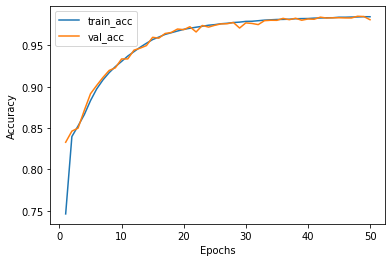

In [12]:
plt.plot(np.arange(1 , len(train_acc)+1, 1), train_acc, label="train_acc")
plt.plot(np.arange(1 , len(train_acc)+1, 1), val_acc, label="val_acc")

plt.legend()
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.show()

In [13]:
# prédiction des données
# about 40 seconds
test_pred = model.predict(X_test)

# score du modèle
score = model.evaluate(X_test, y_test)
print(score)

# Prediction de l'échantillon de test
test_pred = model.predict(X_test)

test_pred_class = np.argmax(test_pred, axis=1)
y_test_class = np.argmax(y_test, axis=1)

print("Performances du modele :")
print(metrics.classification_report(y_test_class, test_pred_class))

9375/9375 [==============================] - 15s 2ms/step - loss: 0.0524 - accuracy: 0.9809
[0.05235668271780014, 0.9809333086013794]
Performances du modele :
              precision    recall  f1-score   support

           1       0.99      0.98      0.99     49231
           2       0.96      0.99      0.98     49302
           3       0.98      0.99      0.98     49147
           4       1.00      0.98      0.99     54062
           5       0.97      0.99      0.98     49228
           6       1.00      0.95      0.97     49030

    accuracy                           0.98    300000
   macro avg       0.98      0.98      0.98    300000
weighted avg       0.98      0.98      0.98    300000



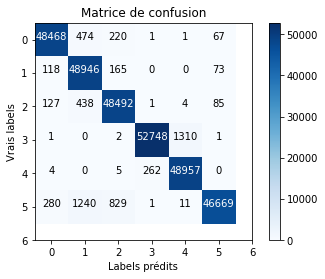

In [14]:
# affiche la matrice de confusion sous forme de tableau coloré
classes = range(0,num_classes)

plt.figure()

# matrice de confusion
cnf_matrix = metrics.confusion_matrix(y_test_class, test_pred_class)

plt.imshow(cnf_matrix, interpolation='nearest',cmap='Blues')
plt.title("Matrice de confusion")
plt.colorbar()
tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes)
plt.yticks(tick_marks, classes)

# texte et couleur
for i, j in itertools.product(range(cnf_matrix.shape[0]), range(cnf_matrix.shape[1])):
    plt.text(j, i, cnf_matrix[i, j],
             horizontalalignment = "center",
             color = "white" if cnf_matrix[i, j] > ( cnf_matrix.max() / 2) else "black")

plt.ylabel('Vrais labels')
plt.xlabel('Labels prédits')
plt.show()

